<img src="../../images/airplane-symbol.jpg" style="float: left; margin: 20px;" width="50" height="50"> 
#  Predicting Flight Delays (<i>a Proof-of-Concept</i>)

Author: Solomon Heng

---

# Regression Modeling (single route, ORD)

## Processes covered in this notebook:
1. [Importing dataset](#(1)-Importing-dataset)
2. [Setting X_train, X_test, y_train & y_test](#(2)-Setting-X_train,-X_test,-y_train-&-y_test)
3. [Box-Cox Transformation](#(3)-Model-(I):-Logistic-Regression)
4. [Model (I): Linear Regression](#(3)-Model-(I):-Linear-Regression)
5. [Model (II): RandomForest](#(4)-Model-(II):-RandomForest)
6. [Model (III): XGBoost](#(5)-Model-(III):-XGBoost)
7. [Model (IV): Neural Networks](#(6)-Model-(IV):-Neural-Networks)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PowerTransformer

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import backend as K

import xgboost as xgb

import scipy.stats as stats

import pickle

from yellowbrick.regressor import ResidualsPlot

sns.set()

Using TensorFlow backend.
C:\Users\solom\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df = pd.read_csv('../datasets/combined_featureselect_data_regression_ord.csv')
df_test = pd.read_csv('../datasets/combined_featureselect_data_regression_test_ord.csv')

In [3]:
pd.set_option('display.max_columns', 100)
df.head()

,DEPARTURE_DELAY,lightning,shower,snow,thunderyshower,SCHEDULED_ARRIVAL_MONTH_sin,SCHEDULED_ARRIVAL_MONTH_cos,SCHEDULED_ARRIVAL_HOUR_sin,SCHEDULED_ARRIVAL_HOUR_cos,DEPARTURE_DELAY^2,DEPARTURE_DELAY SCHEDULED_TIME,DEPARTURE_DELAY DISTANCE,DEPARTURE_DELAY QNH,DEPARTURE_DELAY dew_point,DEPARTURE_DELAY visibility,DEPARTURE_DELAY temp,DEPARTURE_DELAY winddir,DEPARTURE_DELAY windspd,DEPARTURE_DELAY NUM_ARR_AVG_3HOUR,DEPARTURE_DELAY crosswind_comp,AIRLINE_CODE_DL,AIRLINE_CODE_EV,AIRLINE_CODE_F9,AIRLINE_CODE_MQ,AIRLINE_CODE_NK,AIRLINE_CODE_OO,AIRLINE_CODE_UA,ARRIVAL_DELAY
0,-0.166418,0.090927,0.285977,0.204124,0.090927,1.206457,0.812293,2.021528,-0.493486,-0.091275,-0.157526,-0.166418,-0.168103,-0.233574,-0.266359,-0.258338,-0.232967,-0.141420,-0.147161,-0.162442,0.855863,-0.08396,-0.232777,-0.173431,-0.281036,-0.452249,-0.211972,-3.0
1,-0.318121,0.090927,0.285977,0.204124,0.090927,-1.292062,-0.585309,-0.711472,1.246900,-0.092745,-0.319585,-0.318121,-0.318321,-0.263862,-0.293234,-0.302574,-0.306253,-0.271477,-0.308679,-0.225898,-1.168411,-0.08396,-0.232777,-0.173431,-0.281036,2.211172,-0.211972,-17.0
2,-0.318121,0.090927,0.285977,0.204124,0.090927,1.206457,-0.585309,0.102597,1.634391,-0.092745,-0.318171,-0.318121,-0.318270,-0.251048,-0.293234,-0.294881,-0.307205,-0.288654,-0.295379,-0.237050,0.855863,-0.08396,-0.232777,-0.173431,-0.281036,-0.452249,-0.211972,-10.0
3,-0.393972,0.090927,0.285977,0.204124,0.090927,-0.764063,1.323852,1.693312,-0.768567,-0.092010,-0.396688,-0.393972,-0.393903,-0.334923,-0.372862,-0.358350,-0.327192,-0.372087,-0.403057,-0.251782,-1.168411,-0.08396,-0.232777,-0.173431,-0.281036,-0.452249,4.717607,-3.0
4,-0.375010,0.090927,-3.496786,-4.898979,0.090927,0.678458,1.323852,0.338551,-1.065683,-0.092286,-0.377216,-0.375010,-0.375502,-0.241728,-0.352955,-0.275648,-0.397623,-0.300924,-0.360709,-0.260764,0.855863,-0.08396,-0.232777,-0.173431,-0.281036,-0.452249,-0.211972,-7.0


In [4]:
df.shape

(5000, 28)

In [5]:
df.columns

Index(['DEPARTURE_DELAY', 'lightning', 'shower', 'snow', 'thunderyshower',
       'SCHEDULED_ARRIVAL_MONTH_sin', 'SCHEDULED_ARRIVAL_MONTH_cos',
       'SCHEDULED_ARRIVAL_HOUR_sin', 'SCHEDULED_ARRIVAL_HOUR_cos',
       'DEPARTURE_DELAY^2', 'DEPARTURE_DELAY SCHEDULED_TIME',
       'DEPARTURE_DELAY DISTANCE', 'DEPARTURE_DELAY QNH',
       'DEPARTURE_DELAY dew_point', 'DEPARTURE_DELAY visibility',
       'DEPARTURE_DELAY temp', 'DEPARTURE_DELAY winddir',
       'DEPARTURE_DELAY windspd', 'DEPARTURE_DELAY NUM_ARR_AVG_3HOUR',
       'DEPARTURE_DELAY crosswind_comp', 'AIRLINE_CODE_DL', 'AIRLINE_CODE_EV',
       'AIRLINE_CODE_F9', 'AIRLINE_CODE_MQ', 'AIRLINE_CODE_NK',
       'AIRLINE_CODE_OO', 'AIRLINE_CODE_UA', 'ARRIVAL_DELAY'],
      dtype='object')

## Only looking at delays (<420 mins)

_Rationale: Customers would have to be compensated after delays exceed 3 hours (for EU). Since we are looking at US and they DO NOT have any form of obligated compensation for flight delays, we shall use 420mins(7hours) as a benchmark. Also, if delays are long, airlines would likely reschedule the departure to a later timing._

In [6]:
df = df[(df['ARRIVAL_DELAY']<420)]
df_test = df_test[(df_test['ARRIVAL_DELAY']<420)]

In [7]:
df.ARRIVAL_DELAY.mean()

7.9641282565130265

In [8]:
df_test.ARRIVAL_DELAY.mean()

9.012830793905373

## Setting X_train, X_test, y_train & y_test

In [9]:
X_train = df.drop('ARRIVAL_DELAY', axis=1)
y_train = df['ARRIVAL_DELAY']
X_test = df_test.drop('ARRIVAL_DELAY', axis=1)
y_test = df_test['ARRIVAL_DELAY']

In [10]:
X_train.shape

(4990, 27)

In [11]:
X_test.shape

(1247, 27)

## Attempting Box Cox transformation

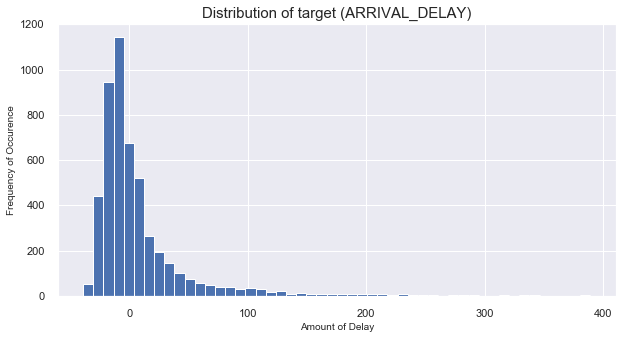

In [12]:
plt.figure(figsize=(10,5))
plt.hist(y_train, bins=50)
plt.title("Distribution of target (ARRIVAL_DELAY)", fontsize=15)
plt.xlabel("Amount of Delay", fontsize=10)
plt.ylabel("Frequency of Occurence", fontsize=10);

# Not normally distributed

In [13]:
pt = PowerTransformer()

In [14]:
y = np.asarray(y_train).reshape(-1,1)
yt = np.asarray(y_test).reshape(-1,1)

In [15]:
y_train = pt.fit_transform(y)
y_test = pt.transform(yt)

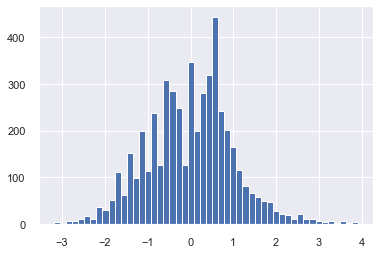

In [16]:
plt.hist(y_train, bins=50);

## Model (1): Linear Regression

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
np.sqrt(-cross_val_score(lr, X_train, y_train, scoring='neg_mean_squared_error').mean())

0.6526260866266401

In [19]:
# R^2 Score
lr.score(X_test, y_test)

0.5886018925618239

In [20]:
# RMSE Score
np.sqrt(mean_squared_error(y_test, lr.predict(X_test)))

0.6370059344275886

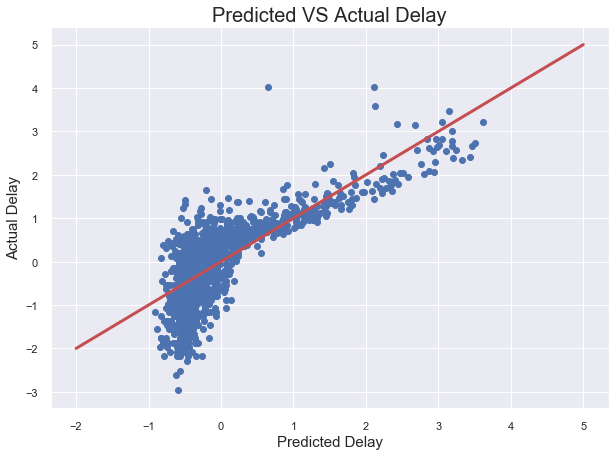

In [21]:
# Visualizing our Predictions vs Actual
pred = lr.predict(X_test)

plt.figure(figsize=(10,7))

plt.scatter(pred,y_test)
plt.plot((-2,5), (-2, 5), c='r', linewidth=3)
plt.xlabel('Predicted Delay', fontsize=15)
plt.ylabel('Actual Delay', fontsize=15)
plt.title('Predicted VS Actual Delay', fontsize=20);

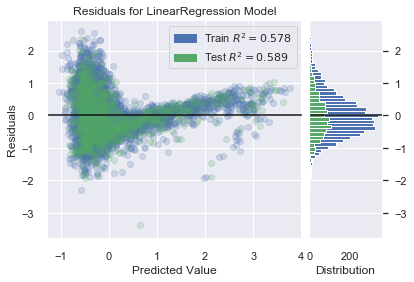

In [22]:
# Visualizing distribution of errors

visualizer = ResidualsPlot(lr, train_alpha=0.2, test_alpha=0.2)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show();

**Seemingly a very badly model for our problem at hand**

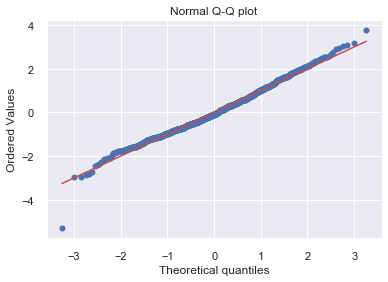

In [23]:
resid = pred.reshape(1247,)-y_test.reshape(1247,)

z = (resid-np.mean(resid))/np.std(resid)

stats.probplot(z, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

## Model (2): RandomForest Regression

In [24]:
rf = RandomForestRegressor()

In [25]:
rf_params = {
  "n_estimators":[50,100],
  "min_samples_split":[10,20],
  "max_depth":[5,10]
}

rf_cv = RandomizedSearchCV(rf, param_distributions=rf_params, n_iter=2, n_jobs=4, verbose=2)

In [26]:
rf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    8.3s finished
C:\Users\solom\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                           

In [27]:
rf_cv.best_params_

{'n_estimators': 50, 'min_samples_split': 20, 'max_depth': 10}

In [28]:
opt_rf = RandomForestRegressor(n_estimators=100, min_samples_split=10, max_depth=10) # CHANGE TO 100, 20, 10 PLS -SOLO

In [29]:
opt_rf.fit(X_train, y_train)

C:\Users\solom\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [30]:
np.sqrt(-cross_val_score(opt_rf, X_train, y_train, scoring='neg_mean_squared_error').mean())

C:\Users\solom\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\solom\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\solom\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\solom\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

0.5791304431308048

In [31]:
# R^2 Score
opt_rf.score(X_test, y_test)

0.6962204595479405

In [32]:
# RMSE Score
np.sqrt(mean_squared_error(y_test, opt_rf.predict(X_test)))

0.5473833636175531

In [33]:
# RMSE in minutes
pt.inverse_transform([[0.5476460746250043]])

array([[7.7999726]])

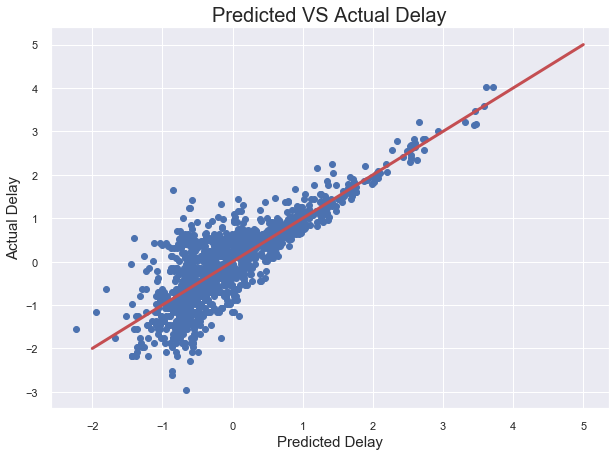

In [34]:
# Visualizing our Predictions vs Actual
pred = opt_rf.predict(X_test)

plt.figure(figsize=(10,7))

plt.scatter(pred,y_test)
plt.plot((-2,5), (-2, 5), c='r', linewidth=3)
plt.xlabel('Predicted Delay', fontsize=15)
plt.ylabel('Actual Delay', fontsize=15)
plt.title('Predicted VS Actual Delay', fontsize=20);

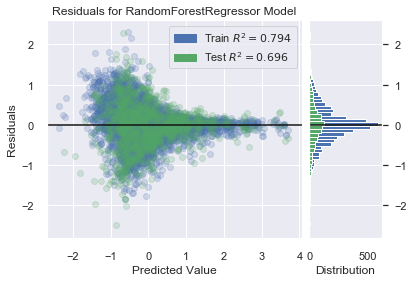

In [35]:
# Visualizing distribution of errors

visualizer = ResidualsPlot(opt_rf, train_alpha=0.2, test_alpha=0.2)

visualizer.fit(X_train, y_train.reshape(4990,))  # Fit the training data to the visualizer
visualizer.score(X_test, y_test.reshape(1247,))  # Evaluate the model on the test data
visualizer.show();

In [36]:
# Predicted value at 1SD
pt.inverse_transform([[1]])

array([[36.94740095]])

**When the delays are low, there are too many possible factors affecting the amount of delays _(e.g pilot mistakes, ATC mistakes, another aircraft on the taxiway causing delays)_. As the delays increase, the possibilities/noise are "even-ed" out by more stable concrete factors. Hence the decrease of variance in prediction as time proceeds on. I believe this heteroscadastic nature is nearly impossible to handle without decreasing the RMSE of the model (which would likely render the model useless practically).**

**Hence to work-around this issue, We can perhaps follow a guideline of only trusting the model**

<b>1. when the predictions are above the 1 SD mark (or when predicted delays are >37mins).</b>

<b>2. OR we can build a multiclass classification model to help bin the delays into 1 hour periods _(which we will do in another model)_.</b>

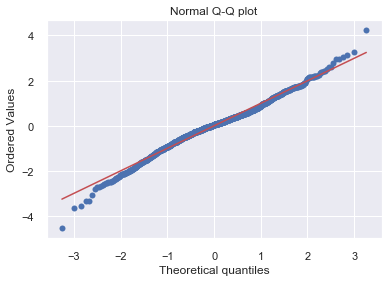

In [37]:
resid = pred.reshape(1247,)-y_test.reshape(1247,)

z = (resid-np.mean(resid))/np.std(resid)

stats.probplot(z, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

In [38]:
# Exporting model

# rf_filename = '../models/regression_ord_rf_model.sav'
# pickle.dump(opt_rf, open(rf_filename, 'wb'))

## Model (3): XGB Regression

In [38]:
xgbr = xgb.XGBRegressor()

In [39]:
xgbr_params = {
  "learning_rate":[0.01, 0.1, 0.2, 0.3],
  "max_depth":[3, 5, 10]
}

xgbr_cv = RandomizedSearchCV(xgbr, param_distributions=xgbr_params, n_iter=2, n_jobs=4, verbose=2)

In [40]:
xgbr_cv.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    6.0s finished


[13:59:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=0,
                                          reg_lambda=1, scale_pos_weight=1,
                                          seed=None, silent=None, subsample=1,
                               

In [41]:
xgbr_cv.best_params_

{'max_depth': 5, 'learning_rate': 0.2}

In [42]:
opt_xgb = xgb.XGBRegressor(max_depth=5, learning_rate=0.1)

In [43]:
opt_xgb.fit(X_train, y_train)

[13:59:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [44]:
np.sqrt(-cross_val_score(opt_xgb, X_train, y_train, scoring='neg_mean_squared_error').mean())

[13:59:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:59:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:59:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:59:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:59:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.5695384611885758

In [45]:
# R^2 Score
opt_xgb.score(X_test, y_test)

0.7137557870107748

In [46]:
# RMSE Score
np.sqrt(mean_squared_error(y_test, opt_xgb.predict(X_test)))

0.5313500076956071

In [47]:
# RMSE in minutes
pt.inverse_transform([[0.5452344913497149]])

array([[7.68062886]])

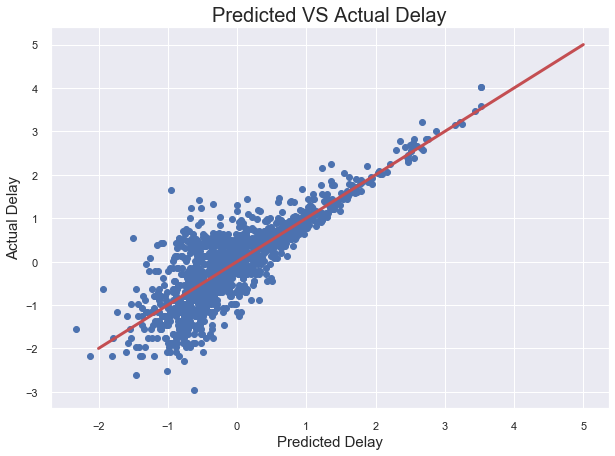

In [48]:
# Visualizing our Predictions vs Actual
pred = opt_xgb.predict(X_test)

plt.figure(figsize=(10,7))

plt.scatter(pred,y_test)
plt.plot((-2,5), (-2, 5), c='r', linewidth=3)
plt.xlabel('Predicted Delay', fontsize=15)
plt.ylabel('Actual Delay', fontsize=15)
plt.title('Predicted VS Actual Delay', fontsize=20);

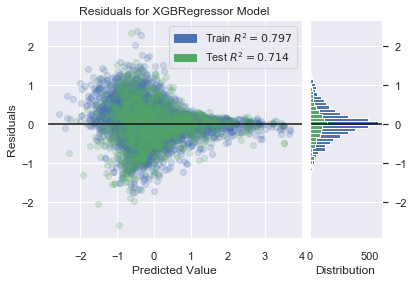

In [49]:
# Visualizing distribution of errors

visualizer = ResidualsPlot(opt_xgb, train_alpha=0.2, test_alpha=0.2)

visualizer.fit(X_train, y_train.reshape(4990,))  # Fit the training data to the visualizer
visualizer.score(X_test, y_test.reshape(1247,))  # Evaluate the model on the test data
visualizer.show();

In [50]:
# Predicted value at 1SD
pt.inverse_transform([[1]])

array([[36.94740095]])

**When the delays are low, there are too many possible factors affecting the amount of delays _(e.g pilot mistakes, ATC mistakes, another aircraft on the taxiway causing delays)_. As the delays increase, the possibilities/noise are "even-ed" out by more stable concrete factors. Hence the decrease of variance in prediction as time proceeds on. I believe this heteroscadastic nature is nearly impossible to handle without decreasing the RMSE of the model (which would likely render the model useless practically).**

**Hence to work-around this issue, We can perhaps follow a guideline of only trusting the model**

<b>1. when the predictions are above the 1 SD mark (or when predicted delays are >37mins).</b>

<b>2. OR we can build a multiclass classification model to help bin the delays into 1 hour periods _(which we will do in another model)_.</b>

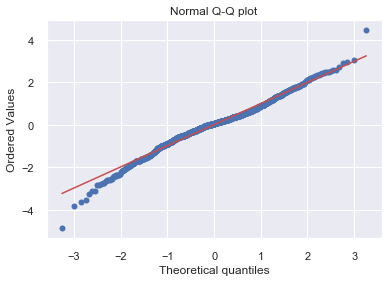

In [51]:
resid = pred.reshape(1247,)-y_test.reshape(1247,)

z = (resid-np.mean(resid))/np.std(resid)

stats.probplot(z, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

In [52]:
# Exporting model

# xgb_filename = '../models/regression_ord_xgb_model.sav'
# pickle.dump(opt_xgb, open(xgb_filename, 'wb'))

## Model (4): Neural Network

In [53]:
model = Sequential()

In [54]:
model.add(Dense(20, 
                input_dim=27, 
                activation='relu'))

# model.add(Dropout(0.5))

model.add(Dense(20, 
                activation='relu'))

#model.add(Dropout(0.5))

#model.add(Dense(150, 
                #activation='relu'))

# Can include dropout (Nope, performed poorer)

model.add(Dense(1))

In [55]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [56]:
es = EarlyStopping(monitor='val_loss', patience=3)

model.compile(optimizer='adam', loss=root_mean_squared_error, metrics=['mse', 'mae'])

In [57]:
model.fit(X_train, y_train, batch_size=32, epochs=1000, validation_split=0.2, callbacks=[es])

Train on 3992 samples, validate on 998 samples
Epoch 1/1000
3992/3992 [==============================] - 1s 137us/step - loss: 0.8362 - mse: 0.7380 - mae: 0.6753 - val_loss: 0.6972 - val_mse: 0.5008 - val_mae: 0.5601
Epoch 2/1000
3992/3992 [==============================] - 0s 47us/step - loss: 0.6614 - mse: 0.4451 - mae: 0.5245 - val_loss: 0.6311 - val_mse: 0.4118 - val_mae: 0.4967
Epoch 3/1000
3992/3992 [==============================] - 0s 47us/step - loss: 0.6184 - mse: 0.3911 - mae: 0.4817 - val_loss: 0.6126 - val_mse: 0.3879 - val_mae: 0.4770
Epoch 4/1000
3992/3992 [==============================] - 0s 45us/step - loss: 0.6060 - mse: 0.3751 - mae: 0.4654 - val_loss: 0.6072 - val_mse: 0.3808 - val_mae: 0.4670
Epoch 5/1000
3992/3992 [==============================] - 0s 47us/step - loss: 0.5977 - mse: 0.3651 - mae: 0.4579 - val_loss: 0.5971 - val_mse: 0.3690 - val_mae: 0.4618
Epoch 6/1000
3992/3992 [==============================] - 0s 46us/step - loss: 0.5929 - mse: 0.3600 - mae: 

In [58]:
model.evaluate(X_test, y_test)

1247/1247 [==============================] - 0s 22us/step


[0.5585050375918531, 0.3199036121368408, 0.42701804637908936]

In [59]:
# RMSE in minutes
pt.inverse_transform([[0.5538895887523627]])

array([[8.11119471]])

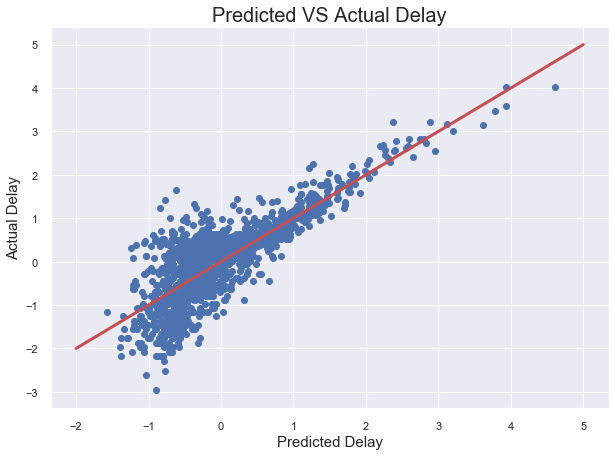

In [60]:
# Visualizing our Predictions vs Actual
pred = model.predict(X_test)

plt.figure(figsize=(10,7))

plt.scatter(pred,y_test)
plt.plot((-2,5), (-2, 5), c='r', linewidth=3)
plt.xlabel('Predicted Delay', fontsize=15)
plt.ylabel('Actual Delay', fontsize=15)
plt.title('Predicted VS Actual Delay', fontsize=20);

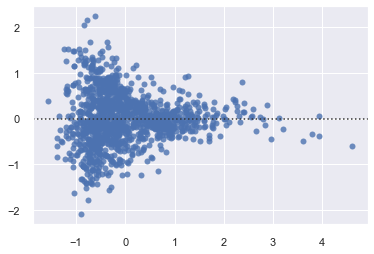

In [61]:
sns.residplot(pred, y_test);

In [62]:
# Predicted value at 1SD
pt.inverse_transform([[1]])

array([[36.94740095]])

**When the delays are low, there are too many possible factors affecting the amount of delays _(e.g pilot mistakes, ATC mistakes, another aircraft on the taxiway causing delays)_. As the delays increase, the possibilities/noise are "even-ed" out by more stable concrete factors. Hence the decrease of variance in prediction as time proceeds on. I believe this heteroscadastic nature is nearly impossible to handle without decreasing the RMSE of the model (which would likely render the model useless practically).**

**Hence to work-around this issue, We can perhaps follow a guideline of only trusting the model**

<b>1. when the predictions are above the 1 SD mark (or when predicted delays are >37mins).</b>

<b>2. OR we can build a multiclass classification model to help bin the delays into 1 hour periods _(which we will do in another model)_.</b>

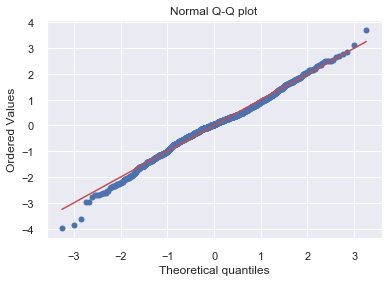

In [63]:
resid = pred.reshape(1247,)-y_test.reshape(1247,)

z = (resid-np.mean(resid))/np.std(resid)

stats.probplot(z, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

In [64]:
# Exporting model

#nn_filename = '../models/regression_nn_model.sav'
#pickle.dump(model, open(nn_filename, 'wb'))